In [1]:
# jupyter specific magic operator
%pylab inline
import matplotlib.patches as mpatches
# import numpy as np
# from numpy import *
# import matplotlib.pyplot as plt
from becquerel import Spectrum
import os
from copy import deepcopy
import numpy as np
from gamma_energies import gamma_energies
from calibration import spectrum_calibration
from lmfit.models import GaussianModel
from lmfit.models import LinearModel
import operator

Populating the interactive namespace from numpy and matplotlib


Since the data was not calibrated in gamma vision, the below function adds 1's to MCA_Cal so Bq runs. It writes the 1's to a new filename while preserving the original data. 

Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_0_1_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_30min_bg_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
SpeFile: Reading file Data_collection/analog_vs_digital/analog_5min_0_1.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
SpeFile: Reading file Data_collection/analog_vs_digital/analog_30min_bg.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0


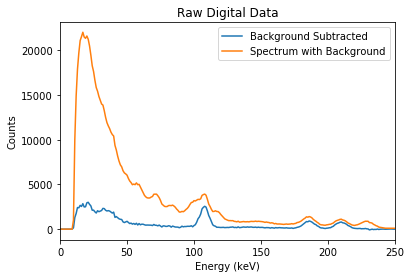

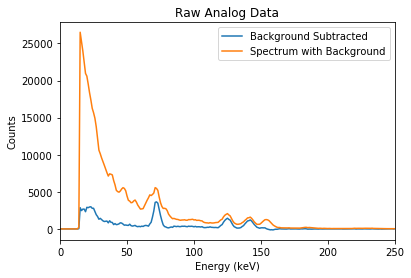

In [2]:
time_1 = 5
time_2 = 30
fname = 'Data_collection/digibase_5min_0_1.Spe'

def fix_spe_zero_cal(fname, fname_new=None):
    if fname_new is None:
        fname_new = '{}_fixed{}'.format(*os.path.splitext(fname))
    with open(fname, 'r') as infile:
        old_lines = [l.rstrip('\n') for l in infile]
    new_lines = deepcopy(old_lines)
    for i, l in enumerate(old_lines):
        if l.startswith('$MCA_CAL'):
            cal = [float(x) for x in old_lines[i + 2].split()]
            if np.isclose(sum(cal), 0.):
                new_lines[i + 2] = '1.0 1.0 1.0'
                print('Fixed line:', i + 2)

    with open(fname_new, 'w') as infile:
        infile.write('\n'.join(new_lines) + '\n')

    return fname_new

spec_1 = Spectrum.from_file(fix_spe_zero_cal(fname))
#Background Subtraction
fname = 'Data_collection/digibase_30min_bg.Spe'
spec_bg = Spectrum.from_file(fix_spe_zero_cal(fname))
spec_bg = spec_bg.counts_vals*time_1/time_2
bgsub = spec_1.counts_vals - spec_bg
fig, ax = plt.subplots()
title('Raw Digital Data')
xlabel('Energy (keV)')
ylabel('Counts')
xlim(0, 250, 5)
plot(bgsub, label = 'Background Subtracted')
plot(spec_1.counts_vals, label = 'Spectrum with Background')
plt.legend()

fname = 'Data_collection/analog_vs_digital/analog_5min_0_1.Spe'
spec_1_analog = Spectrum.from_file((fname))
#Background Subtraction
fname = 'Data_collection/analog_vs_digital/analog_30min_bg.Spe'
spec_bg_analog = Spectrum.from_file((fname))
spec_bg_analog = spec_bg_analog.counts_vals*time_1/time_2
bgsub_analog = spec_1_analog.counts_vals - spec_bg_analog
fig, ax = plt.subplots()
title('Raw Analog Data')
xlabel('Energy (keV)')
ylabel('Counts')
xlim(0, 250, 5)
plot(bgsub_analog, label = 'Background Subtracted')
plot(spec_1_analog.counts_vals, label = 'Spectrum with Background')
plt.legend()

0
108
186
210
1
72
125
142


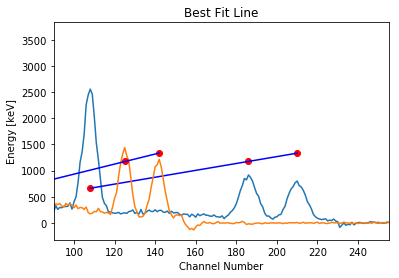

In [8]:
channel_calibration = []
energy_list = gamma_energies('Cs137', 'Co60')
energy_list = sorted(energy_list, key=int)
energy_spectrum = gamma_energies('Cs137', 'Co60')
energy_spectrum = sorted(energy_spectrum, key=int)

channel_width = 15
clean_left = [0, 0]
clean_right = [100, 50]
bgsub_array = [bgsub, bgsub_analog]
for i in range(len(bgsub_array)):
    print(i)

    x_energies = spec_1.energies_kev
    y_counts = bgsub_array[i]
    plot(y_counts)
    xlim(90, 255, 5)

    list_data = np.array(y_counts).tolist()
    iterator = clean_left[i]
    while iterator < (clean_right[i]):
        list_data[iterator] = 0
        iterator += 1
    '''
    merging the data for the calibration
    Also converting merged data into a list so channels can be
    removed easier.
    '''
    data_2_calibrate = list_data

    '''
    Calibrating the new spectrum with the slope and intercept produced
    from the energy calibration.
    '''
    slope, intercept = spectrum_calibration(channel_width, energy_list, data_2_calibrate)
    calibrated_channel = []
    for i in range(0,len(y_counts)):
        calibrated_channel += [i*slope+ intercept]
    calibrated_channel = np.array(calibrated_channel, 'float')
    channel_calibration.append(calibrated_channel)

    '''
    Attempting to iterate through the peaks and identify all of the peaks
    for plotting purposes. All of the peaks are found from the trimmed data
    and the corresponding count rates are found. A list is created and then the
    list is sorted based by the position of the counts.
    '''
    i = 0; channel_max_list = []; energy_list_2 =[]
    gauss_x =[]; gauss_y=[]; fit_channel = []

    while i < len(energy_spectrum):
        channel_max = np.argmax(list_data)
        channel_max_list.append(channel_max)
        energy_list_2.append(list_data[channel_max])
        data_left = channel_max - channel_width
        data_right = channel_max + channel_width
        '''
        Instead of deleting the items from the list. I am placing them to
        zero. The while loop iterates over the peak and sets it to zero.
        '''
        iterator = data_left
        while iterator < (data_right):
            gauss_x.append(iterator)
            gauss_y.append(list_data[iterator])
            x = np.asarray(gauss_x)
            y = np.asarray(gauss_y)
            fit_channel.append(list_data[iterator])
            list_data[iterator] = 0
            iterator += 1
        i += 1
        '''
        information for plotting the Gaussian function.
        '''
        mod  = GaussianModel(prefix='g1_')
        line_mod = LinearModel(prefix='line')
        pars = mod.guess(y, x=x)
        pars.update(line_mod.make_params(intercept=y.min(), slope=0))
        pars.update( mod.make_params())
        pars['g1_center'].set(gauss_x[np.argmax(gauss_y)], min=gauss_x[np.argmax(gauss_y)]\
        - 3)
        pars['g1_sigma'].set(3, min=0.25)
        pars['g1_amplitude'].set(max(gauss_y), min=max(gauss_y)-10)
        mod = mod + line_mod
        out  = mod.fit(y, pars, x=x)
        gauss_x = []; gauss_y = []; fit_channel = []
        #print(out.fit_report(min_correl=10))
        #for key in out.params:
        #    print(key, "=", out.params[key].value, "+/-", out.params[key].stderr)


    energy_channel = list(zip(channel_max_list, energy_list_2))
    energy_channel.sort(key=operator.itemgetter(0))

    '''
    This sequence plots the energy of the peaks and with their corresponding
    energies.
    '''
    #fig = plt.figure()
    #energy_list_2 =[]
    #for channel, energy in energy_channel:
    #    energy_list_2.append(float(energy))
    #for x, y in zip(energy_spectrum, energy_list_2):
    #    x1 = np.linspace(x,x, 10000)
    #    y1 = np.linspace(100, 1000,10000) 
    #    p1 = plt.plot(x1,y1, 'b', linestyle = '--', zorder = 10)
        #plt.annotate('%0.1f keV' % x, xy=(x, y+50), xytext=(x, y+50))
    #    plt.xlim(0, max(energy_spectrum)+100, 100)
    #plt.semilogy(calibrated_channel, y_counts, 'k', zorder = 0)
    #plt.ylabel("Counts")
    #plt.xlabel("Energy(keV)")
    #plt.title("Calibrated Energy Plot - Digital")

Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_0_1_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_30_1_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_60_1_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_90_1_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_30_2_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_60_2_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFil

(0, 1432.492)

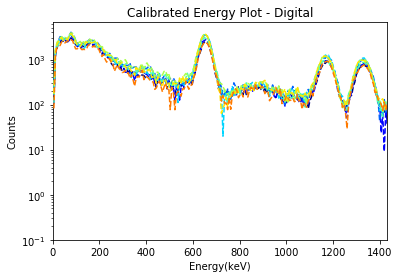

In [4]:
fname1 = ['Data_collection/digibase_5min_0_1.Spe', 'Data_collection/digibase_5min_30_1.Spe', \
         'Data_collection/digibase_5min_60_1.Spe', \
         'Data_collection/digibase_5min_90_1.Spe','Data_collection/digibase_5min_30_2.Spe',  \
         'Data_collection/digibase_5min_60_2.Spe', \
         'Data_collection/digibase_5min_90_2.Spe', 'Data_collection/digibase_5min_0_2.Spe']
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,10)))
for i in fname1:
    spec_2 = Spectrum.from_file(fix_spe_zero_cal(i))
    bgsub2 = spec_2.counts_vals - spec_bg
    calibrated_channel = []
    for i in range(0,len(y_counts)):
        calibrated_channel += [i*slope+ intercept]
    calibrated_channel = np.array(calibrated_channel, 'float')
    plt.semilogy(channel_calibration[0], bgsub2, '--r', zorder = 10, color=next(colors))
plt.ylabel("Counts")
plt.xlabel("Energy(keV)")
plt.title("Calibrated Energy Plot - Digital")
plt.xlim(0, max(energy_spectrum)+100, 100)

SpeFile: Reading file Data_collection/analog_vs_digital/analog_5min_0_1.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
SpeFile: Reading file Data_collection/analog_vs_digital/analog_5min_60_1.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
SpeFile: Reading file Data_collection/analog_vs_digital/analog_5min_30_1.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
SpeFile: Reading file Data_collection/analog_vs_digital/analog_5min_90_1.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
SpeFile: Reading file Data_collection/analog_vs_digital/analog_5min_0_2.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
SpeFile: Reading file Data_collection/analog_vs_digital/analog_5min_30_2.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
SpeFile: Reading file Data_collection/analog_vs_digital/analog_5mi

(0, 1432.492)

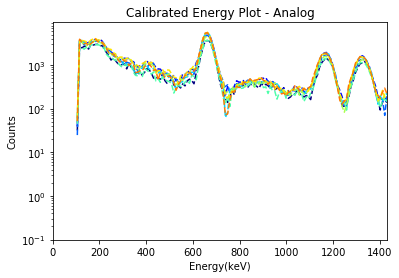

In [9]:
fname2 = ['Data_collection/analog_vs_digital/analog_5min_0_1.Spe', \
         'Data_collection/analog_vs_digital/analog_5min_60_1.Spe', \
         'Data_collection/analog_vs_digital/analog_5min_30_1.Spe', \
         'Data_collection/analog_vs_digital/analog_5min_90_1.Spe', \
          'Data_collection/analog_vs_digital/analog_5min_0_2.Spe', \
          'Data_collection/analog_vs_digital/analog_5min_30_2.Spe', \
        'Data_collection/analog_vs_digital/analog_5min_60_2.Spe', \
         'Data_collection/analog_vs_digital/analog_5min_90_2.Spe']
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,10)))
for i in fname2:
    spec_2 = Spectrum.from_file(i)
    bgsub2 = spec_2.counts_vals - spec_bg_analog
    calibrated_channel = []
    plt.semilogy(channel_calibration[1], bgsub2, '--r', zorder = 10, color=next(colors))
plt.ylabel("Counts")
plt.xlabel("Energy(keV)")
plt.title("Calibrated Energy Plot - Analog")
plt.xlim(0, max(energy_spectrum)+100, 100)

Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_0_1_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_30_1_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_60_1_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_90_1_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_30_2_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFile: Reading file Data_collection/digibase_5min_60_2_fixed.Spe
Unknown line:  $PRESETS:
Unknown line:  None
Unknown line:  0
Unknown line:  0
Fixed line: 1046
SpeFil

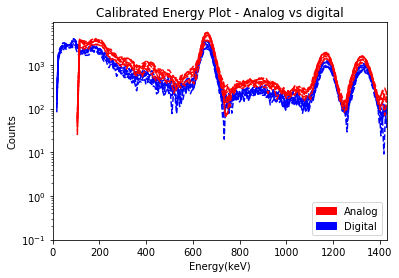

In [10]:
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,10)))
for i in fname1:
    spec_2 = Spectrum.from_file(fix_spe_zero_cal(i))
    bgsub2 = spec_2.counts_vals - spec_bg
    calibrated_channel = []
    for i in range(0,len(y_counts)):
        calibrated_channel += [i*slope+ intercept]
    calibrated_channel = np.array(calibrated_channel, 'float')
    plt.semilogy(channel_calibration[0], bgsub2, '--b', zorder = 0)
plt.ylabel("Counts")
plt.xlabel("Energy(keV)")
plt.xlim(0, max(energy_spectrum)+100, 100)

for i in fname2:
    spec_2 = Spectrum.from_file(i)
    bgsub2 = spec_2.counts_vals - spec_bg_analog
    calibrated_channel = []
    plt.semilogy(channel_calibration[1], bgsub2, '--r', zorder = 10)
plt.ylabel("Counts")
plt.xlabel("Energy(keV)")
plt.title("Calibrated Energy Plot - Analog vs digital")
plt.xlim(0, max(energy_spectrum)+100, 100)
red_patch = mpatches.Patch(color='Red', label='Analog')
red_patch1 = mpatches.Patch(color='Blue', label='Digital')
plt.legend(handles=[red_patch, red_patch1],loc="lower right")

# The hit key

```
HT
1. Detector ID (see table of detector IDs) 
2. x position of interaction in cm
3. y position of interaction in cm
4: z position of interaction in cm
5: Energy deposit in keV
6: Time since start of event in seconds
7: Vector of IDs of the interactions which contributed to this hit
```

In [7]:
figure_counter=0; count_list = []; bin_centers_list = []
for run in fname:
    energies = [];l_old = ""; counter = 0; iterator = 0
    with open(run, 'r') as infile:
        for i, l in enumerate(infile):
            if l.startswith('HTsim') and l_old.startswith('HTsim'):
                #==============
                #Checking to see if there were multiple hits from a single particle in the detector 
                #If there were multiple countes, the energies of the particles are summed together
                #==============
                data = [x.strip() for x in l.split(';')]  # break on `;` and strip whitespace
                energy_update = float(data[4])
                energy_keV = energy_old + energy_update #updating the energy to the sum of the particles
                energies[iterator-counter] = (energy_keV) #updates the list of energies and replaces the previous
                #energy with the new summed energy
                energy_old = energy_keV
                counter+=1
            elif l.startswith('HTsim'):
                data = [x.strip() for x in l.split(';')]  # break on `;` and strip whitespace
                energy_keV = float(data[4])
                energy_old = energy_keV #storing the current energy as the new old energy
                l_old = str(data[0])
                energies.append(energy_keV)
                counter+=1
                iterator+=1
            else:
                #================
                #Initializing all of the variables back to 0 since HTsim was not hit
                #=========
                l_old = ""
                energy = 0
                counter = 0
            if i % 100000 == 0:
                print(i)
    figure(figure_counter)
    nrg = np.array(energies)
    counts, bin_edges = np.histogram(nrg, bins=1000)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    xlim(0, max((bin_centers)+100))
    semilogy(bin_centers, counts)
    counts, bin_edges = np.histogram(nrg, bins=np.linspace(0, max(energies)+100))
    count_list.append(counts)
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    bin_centers_list.append(bin_centers)
    elements = ['Cs137 Spectrum', 'Cs137 & Co60 Spectrum']
    title(elements[figure_counter])
    xlabel('Energy (keV)')
    ylabel('Counts')
    figure_counter+=1

FileNotFoundError: [Errno 2] No such file or directory: 'D'

In [ ]:
iterator = 0
for i, k in zip(bin_centers_list, count_list):
    figure(iterator)
    semilogy(i, k, linestyle='steps-mid', color='r')
    iterator+=1